### Import of Libraries

In [152]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import shap
import pycaret as pc

from pca import pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pycaret.classification import *

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (13,8)

### Getting Data

The study collects the data using a microcontroller. It was linked to a ZigBee radio, which was used to relay the data to a recording station. A digital camera was utilised to assess whether or not the room was inhabited. Every minute, the camera time stamped an image, which was then manually examined to identify the data. The humidity ratio is another additional variable in the data model, calculated as ( W = 0.622*(pw/(p-pw)) ).

The data was collected in February in Mons, Belgium, during the winter. The room was heated by hot water radiators, which kept the temperature above 19 degrees Celsius. The models are tested for data sets with the office door open and closed in order to estimate the difference in occupancy detection accuracy provided by the models. The measurements were obtained at 14-second intervals/3-4 times every minute, and then averaged for that minute.

Attribute Information is as follows:

1. date time year-month-day hour:minute:second
2. Temperature, in Celsius
3. Relative Humidity, %
4. Light, in Lux
5. CO2, in ppm
6. Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
7. Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status

In [153]:
df = pd.read_csv('datatraining.csv')
#df=df.head(5000)
#df['date'] = df['date'].str.slice(start=11)
#df['date'] = df['date'].apply(lambda x: timeToNum(x))
df=df.drop(columns=["id","date"])

In [154]:
df.head(5)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.18,27.2720,426.0,721.25,0.004793,1
1,23.15,27.2675,429.5,714.00,0.004783,1
2,23.15,27.2450,426.0,713.50,0.004779,1
3,23.15,27.2000,426.0,708.25,0.004772,1
4,23.10,27.2000,426.0,704.50,0.004757,1


In [155]:
df.info()
print("Number of duplicated rows is: ", df.duplicated().sum())
print("Number of rows with NaNs is: ", df.isna().any(axis=1).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    8143 non-null   float64
 1   Humidity       8143 non-null   float64
 2   Light          8143 non-null   float64
 3   CO2            8143 non-null   float64
 4   HumidityRatio  8143 non-null   float64
 5   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 381.8 KB
Number of duplicated rows is:  867
Number of rows with NaNs is:  0


### Exploratory Data Analysis

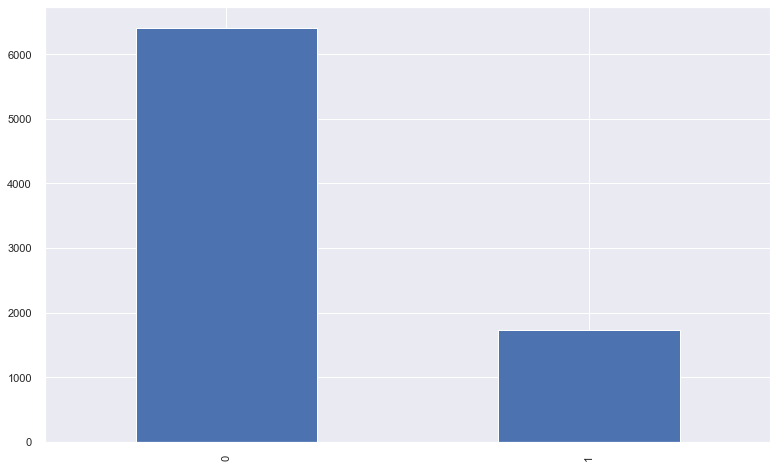

In [156]:
df['Occupancy'].value_counts().plot(kind='bar')
plt.ylabel('')
plt.show()

##### Extracting Attribute Matrix

In [157]:
X = df.drop(columns=['Occupancy'])
X.head(5)

,Temperature,Humidity,Light,CO2,HumidityRatio
0,23.18,27.2720,426.0,721.25,0.004793
1,23.15,27.2675,429.5,714.00,0.004783
2,23.15,27.2450,426.0,713.50,0.004779
3,23.15,27.2000,426.0,708.25,0.004772
4,23.10,27.2000,426.0,704.50,0.004757


##### Original Data

<AxesSubplot:>

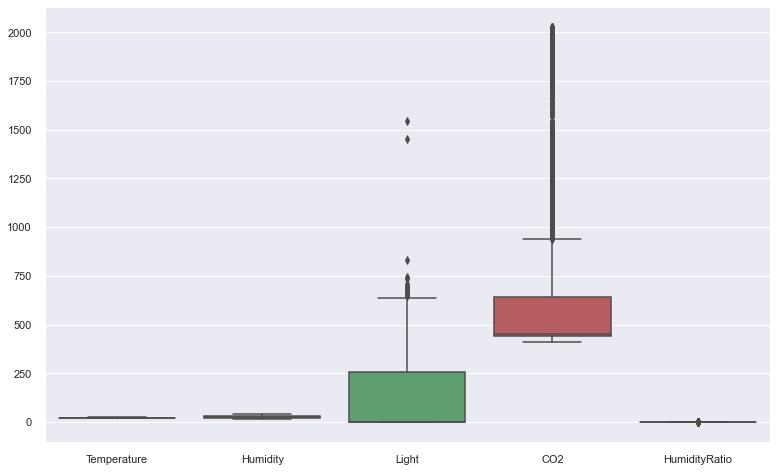

In [158]:
sns.boxplot(data=X)

##### Standardized Data

In [159]:
# Generates a Standardized matrix with mean zero and variance is 1

Xs = StandardScaler().fit_transform(X)  
Xcols = X.columns
X = pd.DataFrame(Xs)
X.columns = Xcols
X.head(5)

,Temperature,Humidity,Light,CO2,HumidityRatio
0,2.518470,0.278526,1.573763,0.364948,1.091757
1,2.488967,0.277713,1.591735,0.341881,1.080555
2,2.488967,0.273645,1.573763,0.340290,1.075888
3,2.488967,0.265508,1.573763,0.323587,1.066555
4,2.439796,0.265508,1.573763,0.311655,1.049523


In [160]:
X.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio
count,8.143000e+03,8.143000e+03,8.143000e+03,8.143000e+03,8.143000e+03
mean,7.818326e-16,4.467615e-16,2.233807e-16,-1.884775e-16,1.116904e-16
std,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00,1.000061e+00
min,-1.592248e+00,-1.624791e+00,-6.137261e-01,-6.165933e-01,-1.394355e+00
25%,-9.038502e-01,-1.000115e+00,-6.137261e-01,-5.330748e-01,-9.201475e-01
50%,-2.252867e-01,8.877312e-02,-6.137261e-01,-4.869407e-01,-7.243751e-02
75%,7.581387e-01,8.681862e-01,7.027469e-01,1.027265e-01,5.742528e-01
max,2.518470e+00,2.420232e+00,7.326619e+00,4.524170e+00,3.066492e+00


##### Box and Whisker Plots

<AxesSubplot:>

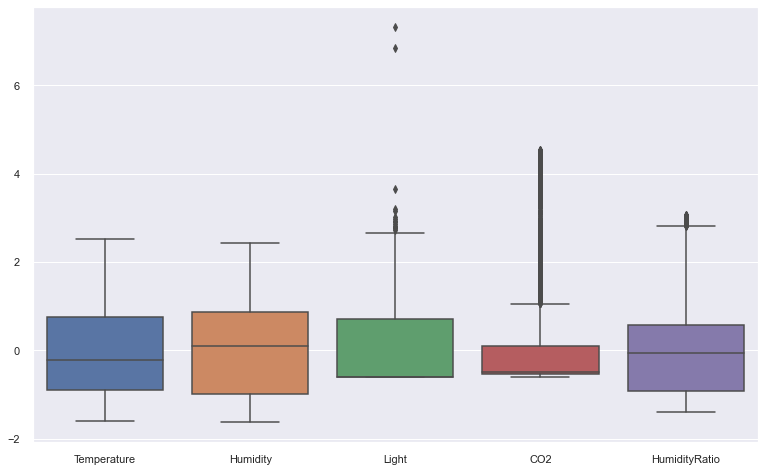

In [161]:
sns.boxplot(data=X)

##### Correlation Matrix

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Temperature'),
  Text(0, 1.5, 'Humidity'),
  Text(0, 2.5, 'Light'),
  Text(0, 3.5, 'CO2'),
  Text(0, 4.5, 'HumidityRatio')])

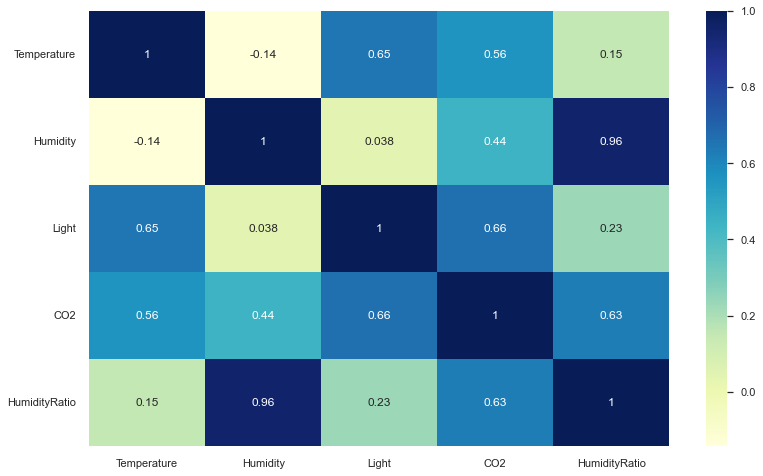

In [162]:
sns.heatmap(X.corr(), cmap='YlGnBu', annot=True)
plt.yticks(rotation=0)

##### Pair Plot

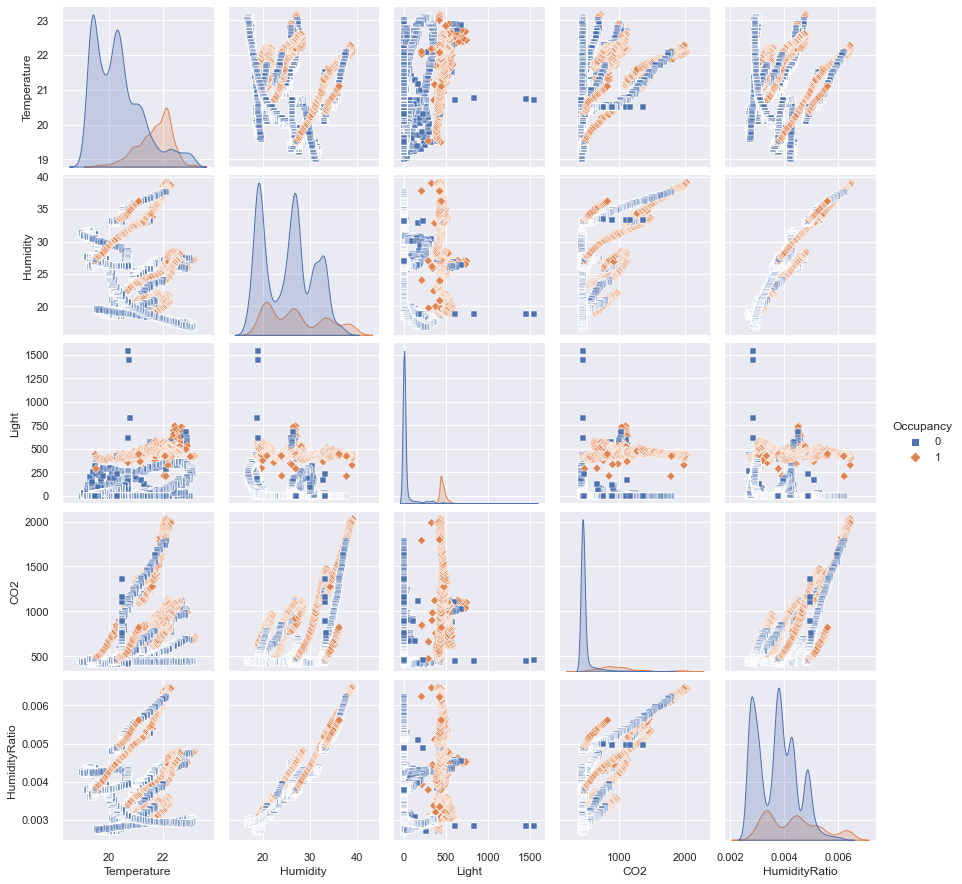

In [163]:
sns.pairplot(df, hue='Occupancy', markers=["s", "D"], kind="scatter")
plt.show()

### Principal Component Analysis

##### Covariance

In [164]:
cova = np.cov(X.transpose())
covaMatrix = pd.DataFrame(cova)
covaMatrix.head(15)

,0,1,2,3,4
0,1.000123,-0.141777,0.650022,0.559963,0.151780
1,-0.141777,1.000123,0.037833,0.439077,0.955315
2,0.650022,0.037833,1.000123,0.664104,0.230449
3,0.559963,0.439077,0.664104,1.000123,0.626633
4,0.151780,0.955315,0.230449,0.626633,1.000123


In [165]:
pcss = PCA()
pcss.fit_transform(X)
A = pcss.components_.T 
Lambda = pcss.explained_variance_ 

##### Eigenvalues and Eigenvectors

In [166]:
print(f'Eigenvectors:\n{A}')
print(f'Eigenvalues:\n{Lambda}')

Eigenvectors:
[[ 0.34385624  0.5358643  -0.71337364  0.22538247 -0.18685057]
 [ 0.39566375 -0.57411081  0.00924853  0.22696629 -0.67988804]
 [ 0.41414891  0.44461199  0.66542367  0.43317687  0.01923538]
 [ 0.55006986  0.12010568  0.11093843 -0.81726459 -0.05262155]
 [ 0.50111567 -0.41369197 -0.18951653  0.2052448   0.70689468]]
Eigenvalues:
[2.73685981e+00 1.69967935e+00 3.48872139e-01 2.14393433e-01
 8.09358836e-04]


In [167]:
model = pca()
# Fit transform
out = model.fit_transform(X)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [5] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [5] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [168]:
# Top features in signifacnt PCs
out['topfeat']

,PC,feature,loading,type
0,PC1,CO2,0.550070,best
1,PC2,Humidity,-0.574111,best
2,PC3,Temperature,-0.713374,best
3,PC3,Light,0.665424,weak
4,PC1,HumidityRatio,0.501116,weak


##### PCs

In [169]:
out['PC']

,PC1,PC2,PC3
0,2.375810,1.481548,-0.913234
1,2.354485,1.476060,-0.880672
2,2.342218,1.472145,-0.891961
3,2.325134,1.478671,-0.892121
4,2.293128,1.457935,-0.855139
...,...,...,...
8138,2.879268,-0.897206,0.468321
8139,2.866476,-0.877949,0.472498
8140,2.925637,-0.874514,0.433447
8141,2.990828,-0.895826,0.435690


In [170]:
A = out['loadings'].T
print(A)

                    PC1       PC2       PC3
Temperature    0.343856  0.535864 -0.713374
Humidity       0.395664 -0.574111  0.009249
Light          0.414149  0.444612  0.665424
CO2            0.550070  0.120106  0.110938
HumidityRatio  0.501116 -0.413692 -0.189517


##### Scree Plot

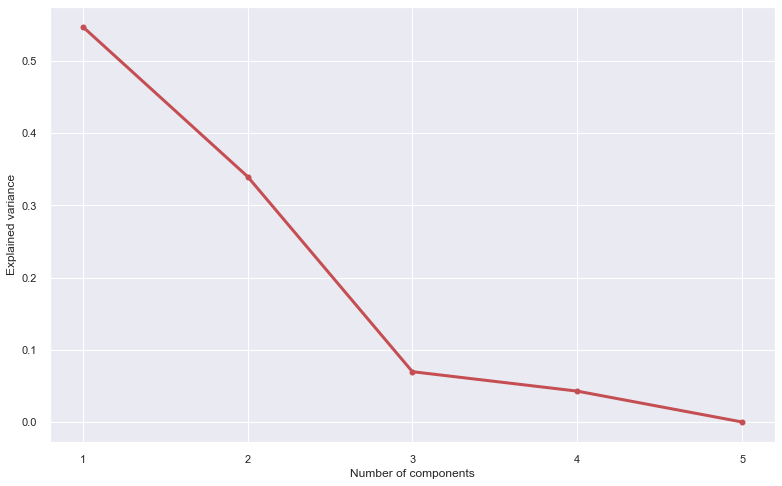

In [171]:
VR = out['variance_ratio']
x = np.arange(len(VR)) + 1
plt.plot(x, VR, 'ro-', lw=3)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance') 
plt.show()

##### Explained Variance

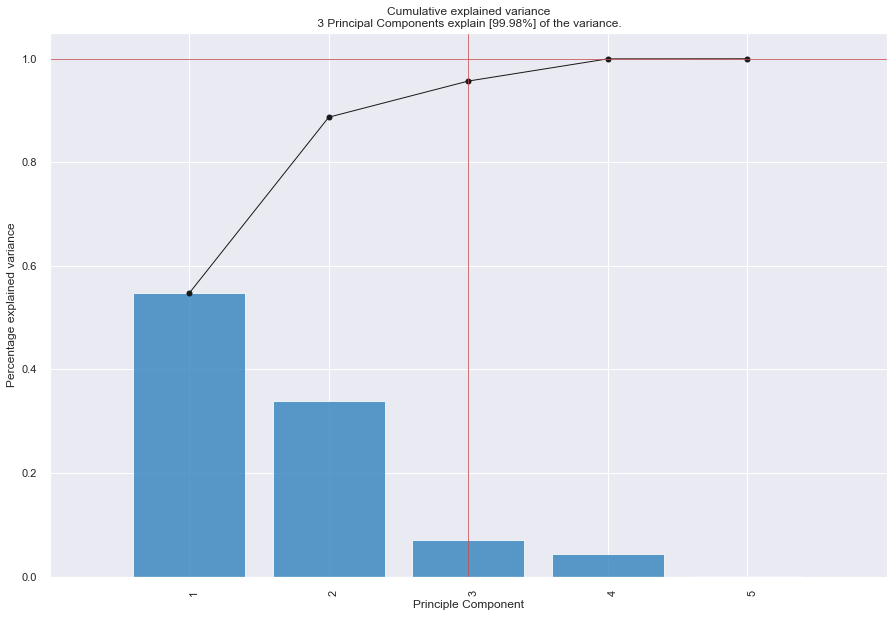

<Figure size 936x576 with 0 Axes>

In [172]:
model.plot();

##### PC Coefficient Plot

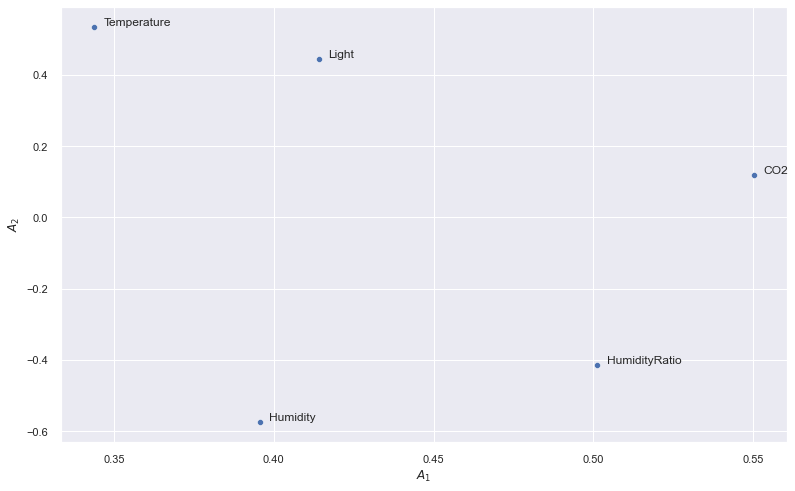

In [173]:
variables = list(df.columns)
sns.scatterplot(data=A, x="PC1", y="PC2")
plt.xlabel('$A_1$')
plt.ylabel('$A_2$')
for i in range(A.shape[0]):
     plt.text(x=A.PC1[i]+0.003,y=A.PC2[i]+0.003, s=variables[i])

##### BiPlot

[pca] >Plot PC1 vs PC2 with loadings.


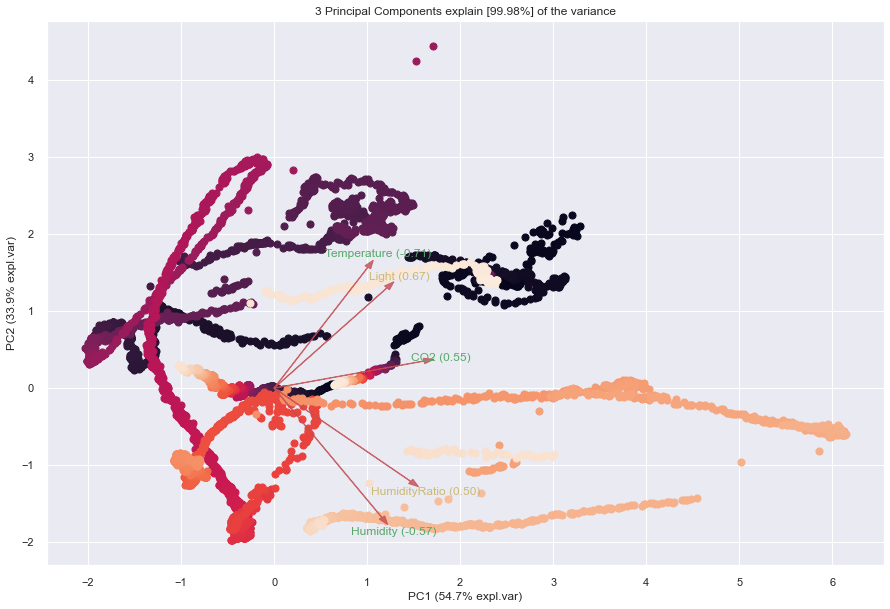

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:title={'center':'3 Principal Components explain [99.98%] of the variance'}, xlabel='PC1 (54.7% expl.var)', ylabel='PC2 (33.9% expl.var)'>)

In [174]:
model.biplot(label=False, legend=False, cmap=None)

[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


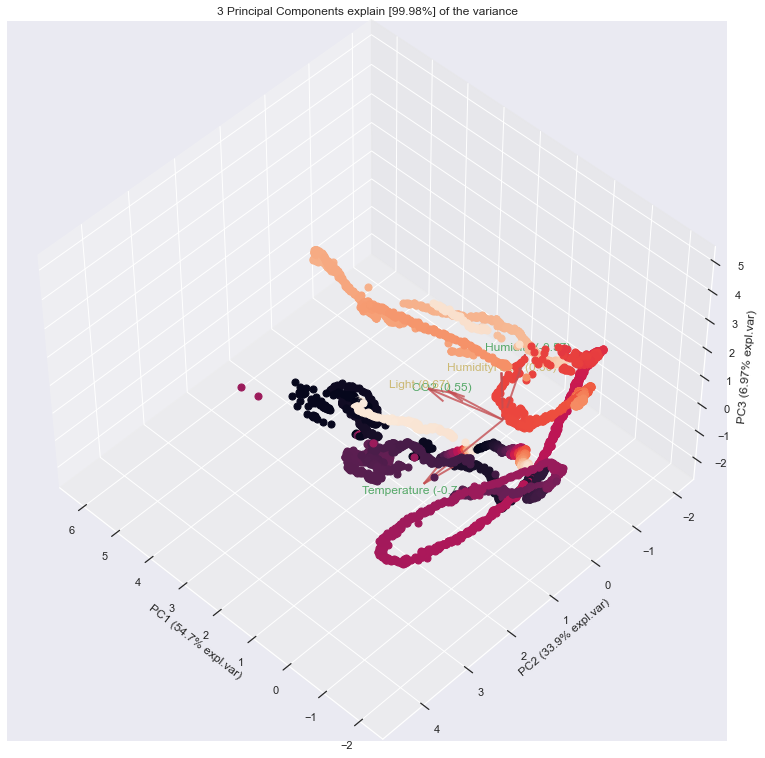

(<Figure size 1080x720 with 2 Axes>,
 <Axes3D:title={'center':'3 Principal Components explain [99.98%] of the variance'}, xlabel='PC1 (54.7% expl.var)', ylabel='PC2 (33.9% expl.var)'>)

In [175]:
model.biplot3d(label=False, legend=False, cmap=None)

### Classification

In [176]:
data = df#.sample(frac=0.9, random_state=786)
#data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
#data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
#
# print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (8143, 6)


In [177]:
clf = setup(data=data, target='Occupancy', train_size=0.7, session_id=666)

,Description,Value
0,session_id,666
1,Target,Occupancy
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8143, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [178]:
best_model = compare_models()
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9954,0.9994,0.9918,0.9870,0.9894,0.9865,0.9865,0.2170
rf,Random Forest Classifier,0.9942,0.9993,0.9893,0.9838,0.9865,0.9828,0.9829,0.2780
lightgbm,Light Gradient Boosting Machine,0.9942,0.9991,0.9902,0.9830,0.9865,0.9828,0.9829,0.0760
dt,Decision Tree Classifier,0.9930,0.9893,0.9828,0.9844,0.9835,0.9791,0.9791,0.0230
ada,Ada Boost Classifier,0.9926,0.9989,0.9893,0.9766,0.9829,0.9782,0.9782,0.1270
gbc,Gradient Boosting Classifier,0.9921,0.9987,0.9852,0.9781,0.9816,0.9766,0.9766,0.2720
qda,Quadratic Discriminant Analysis,0.9886,0.9942,0.9959,0.9531,0.9740,0.9667,0.9671,0.0210
knn,K Neighbors Classifier,0.9884,0.9971,0.9934,0.9546,0.9736,0.9661,0.9665,1.1310
ridge,Ridge Classifier,0.9877,0.0000,0.9992,0.9468,0.9722,0.9643,0.9650,0.0220
lda,Linear Discriminant Analysis,0.9875,0.9931,0.9992,0.9460,0.9718,0.9638,0.9644,0.0200


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=666, verbose=0,
                     warm_start=False)

##### Classifiers

From the above provided results, we select these as our candidate models:
- Extra Trees Classifier
- Light Gradient Boosting Machine
- Random Forest Classifiers

##### Extra Trees Classifier

In [179]:
et = create_model('et')
tunedET = tune_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9860,0.9946,0.9917,0.9449,0.9677,0.9588,0.9592
1,0.9947,0.9973,1.0000,0.9760,0.9879,0.9845,0.9846
2,0.9807,0.9916,0.9918,0.9237,0.9565,0.9441,0.9451
3,0.9912,0.9965,1.0000,0.9606,0.9799,0.9743,0.9746
4,0.9930,0.9974,1.0000,0.9683,0.9839,0.9794,0.9796
5,0.9877,0.9916,1.0000,0.9457,0.9721,0.9642,0.9649
6,0.9860,0.9942,0.9836,0.9524,0.9677,0.9588,0.9590
7,0.9860,0.9935,1.0000,0.9385,0.9683,0.9593,0.9601
8,0.9877,0.9959,1.0000,0.9457,0.9721,0.9642,0.9649


In [180]:
evaluate_model(tunedET)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,entropy
max_depth,4
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.01
min_impurity_split,None


##### Light Gradient Boosting Machine

In [181]:
lightgbm = create_model('lightgbm')
tunedLightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9947,0.9999,0.9835,0.9917,0.9876,0.9842,0.9842
1,0.9982,1.0000,1.0000,0.9919,0.9959,0.9948,0.9948
2,0.9895,0.9993,0.9836,0.9677,0.9756,0.9689,0.9690
3,0.9895,0.9997,0.9836,0.9677,0.9756,0.9689,0.9690
4,0.9930,0.9998,0.9836,0.9836,0.9836,0.9791,0.9791
5,0.9912,0.9981,0.9836,0.9756,0.9796,0.9740,0.9740
6,0.9947,0.9997,0.9918,0.9837,0.9878,0.9844,0.9844
7,0.9965,0.9999,1.0000,0.9839,0.9919,0.9896,0.9897
8,0.9965,0.9998,1.0000,0.9839,0.9919,0.9896,0.9897


In [182]:
evaluate_model(tunedLightgbm)

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.5
max_depth,-1
min_child_samples,46
min_child_weight,0.001
min_split_gain,0.8
n_estimators,120


##### Random Forest Classifiers

In [197]:
rf = create_model('rf')
tunedRF = tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9912,0.9979,0.9917,0.9677,0.9796,0.9740,0.9741
1,0.9947,0.9999,1.0000,0.9760,0.9879,0.9845,0.9846
2,0.9825,0.9983,0.9918,0.9308,0.9603,0.9491,0.9499
3,0.9860,0.9980,0.9836,0.9524,0.9677,0.9588,0.9590
4,0.9930,0.9997,1.0000,0.9683,0.9839,0.9794,0.9796
5,0.9842,0.9971,0.9918,0.9380,0.9641,0.9540,0.9546
6,0.9895,0.9994,1.0000,0.9531,0.9760,0.9693,0.9697
7,0.9912,0.9994,1.0000,0.9606,0.9799,0.9743,0.9746
8,0.9860,0.9998,1.0000,0.9385,0.9683,0.9593,0.9601


In [198]:
evaluate_model(tunedRF)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,entropy
max_depth,10
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.001
min_impurity_split,None


### Classification+PCA

In [185]:
clfPCA = setup(data=data, target='Occupancy', train_size=0.7, session_id=666, normalize = True, pca = True, pca_components = 3)

,Description,Value
0,session_id,666
1,Target,Occupancy
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8143, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [186]:
bestModelPCA = compare_models()
bestModelPCA

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9951,0.9997,0.9926,0.9846,0.9886,0.9854,0.9855,0.1990
lightgbm,Light Gradient Boosting Machine,0.9933,0.9994,0.9877,0.9814,0.9845,0.9802,0.9803,0.0670
rf,Random Forest Classifier,0.9926,0.9995,0.9901,0.9758,0.9829,0.9782,0.9783,0.2650
knn,K Neighbors Classifier,0.9919,0.9983,0.9852,0.9774,0.9812,0.9761,0.9762,0.0510
dt,Decision Tree Classifier,0.9909,0.9864,0.9787,0.9788,0.9786,0.9728,0.9729,0.0210
gbc,Gradient Boosting Classifier,0.9900,0.9989,0.9869,0.9672,0.9769,0.9705,0.9706,0.2980
ridge,Ridge Classifier,0.9886,0.0000,0.9992,0.9503,0.9741,0.9668,0.9673,0.0140
lda,Linear Discriminant Analysis,0.9886,0.9943,0.9992,0.9503,0.9741,0.9668,0.9673,0.0180
ada,Ada Boost Classifier,0.9875,0.9968,0.9910,0.9529,0.9715,0.9635,0.9639,0.1320
svm,SVM - Linear Kernel,0.9868,0.0000,0.9910,0.9499,0.9700,0.9615,0.9620,0.0170


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=666, verbose=0,
                     warm_start=False)

##### Extra Trees Classifier on PCA model

In [187]:
etP = create_model('et')
tunedETp = tune_model(etP)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9877,0.9991,1.0000,0.9453,0.9719,0.9640,0.9647
1,0.9947,0.9987,1.0000,0.9760,0.9879,0.9845,0.9846
2,0.9807,0.9980,0.9918,0.9237,0.9565,0.9441,0.9451
3,0.9912,0.9980,1.0000,0.9606,0.9799,0.9743,0.9746
4,0.9895,0.9995,1.0000,0.9531,0.9760,0.9693,0.9697
5,0.9842,0.9961,0.9918,0.9380,0.9641,0.9540,0.9546
6,0.9895,0.9990,1.0000,0.9531,0.9760,0.9693,0.9697
7,0.9860,0.9984,1.0000,0.9385,0.9683,0.9593,0.9601
8,0.9860,0.9986,1.0000,0.9385,0.9683,0.9593,0.9601


In [188]:
evaluate_model(tunedETp)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,entropy
max_depth,10
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.001
min_impurity_split,None


##### Light Gradient Boosting Machine on PCA model

In [189]:
lightgbmP = create_model('lightgbm')
tunedLightgbmP = tune_model(lightgbmP)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9877,0.9994,0.9669,0.9750,0.9710,0.9632,0.9632
1,0.9965,0.9998,1.0000,0.9839,0.9919,0.9896,0.9897
2,0.9877,0.9978,0.9918,0.9528,0.9719,0.9640,0.9644
3,0.9947,0.9997,0.9918,0.9837,0.9878,0.9844,0.9844
4,0.9965,0.9998,1.0000,0.9839,0.9919,0.9896,0.9897
5,0.9877,0.9962,0.9836,0.9600,0.9717,0.9638,0.9639
6,0.9947,0.9999,0.9836,0.9917,0.9877,0.9843,0.9843
7,0.9860,0.9981,0.9754,0.9597,0.9675,0.9585,0.9586
8,0.9930,0.9997,0.9918,0.9758,0.9837,0.9793,0.9793


In [190]:
evaluate_model(tunedLightgbmP)

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.5
max_depth,-1
min_child_samples,46
min_child_weight,0.001
min_split_gain,0.8
n_estimators,120


##### Random Trees Classifier on PCA model

In [191]:
rfP = create_model('rf')
tunedRFp = tune_model(rfP)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9912,0.9979,0.9917,0.9677,0.9796,0.9740,0.9741
1,0.9947,0.9999,1.0000,0.9760,0.9879,0.9845,0.9846
2,0.9825,0.9983,0.9918,0.9308,0.9603,0.9491,0.9499
3,0.9860,0.9980,0.9836,0.9524,0.9677,0.9588,0.9590
4,0.9930,0.9997,1.0000,0.9683,0.9839,0.9794,0.9796
5,0.9842,0.9971,0.9918,0.9380,0.9641,0.9540,0.9546
6,0.9895,0.9994,1.0000,0.9531,0.9760,0.9693,0.9697
7,0.9912,0.9994,1.0000,0.9606,0.9799,0.9743,0.9746
8,0.9860,0.9998,1.0000,0.9385,0.9683,0.9593,0.9601


In [192]:
evaluate_model(tunedRFp)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,entropy
max_depth,10
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.001
min_impurity_split,None


### Explainable AI with Shapley values

##### SHAP summary plot

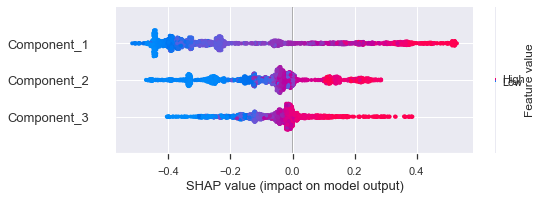

In [193]:
interpret_model(tunedETp, plot='summary')

##### Visualizing Predictions

In [195]:
interpret_model(tunedETp, plot='reason')